In [1]:
import os
import copy
import time
import random
import numpy as np
import pandas as pd
from PIL import Image

import matplotlib.pyplot as plt

import torch
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import models, transforms

from __future__ import print_function
from __future__ import division

from data import train_test_split

from train import train_one_epoch

print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  2.3.1+cu121
Torchvision Version:  0.18.1+cu121


In [3]:
ROOT_PATH = "/kaggle/input/"

# Name of the dataset
IMAGE_DATA = "sdnet2018/SDNET2018/"

# define the path to the cracked and noncracked images
CRACKED_IMAGES_PATH = os.path.join(ROOT_PATH, IMAGE_DATA, "cracked")
NONCRACKED_IMAGES_PATH = os.path.join(ROOT_PATH, IMAGE_DATA, "non-cracked")

# define the train & test split
TRAIN_VALID_SPLIT = 0.2
VALID_TEST_SPLIT = 0.5

# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

# Data Prep

In [4]:
# cracked => 1, noncracked => 0
cracked_images = [[os.path.join(CRACKED_IMAGES_PATH, filename), 1] for filename in sorted(os.listdir(CRACKED_IMAGES_PATH))]
noncracked_images = [[os.path.join(NONCRACKED_IMAGES_PATH, filename), 0] for filename in sorted(os.listdir(NONCRACKED_IMAGES_PATH))]

noncracked_images = random.choices(noncracked_images, k=len(cracked_images))

all_images = cracked_images + noncracked_images

print(f"Dataset size: {len(all_images)}")

df = pd.DataFrame({'images': [img[0] for img in all_images], 'labels': [img[1] for img in all_images]})
df.head()

Dataset size: 5216


,images,labels
0,/kaggle/input/sdnet2018/SDNET2018/cracked/001-...,1
1,/kaggle/input/sdnet2018/SDNET2018/cracked/001-...,1
2,/kaggle/input/sdnet2018/SDNET2018/cracked/001-...,1
3,/kaggle/input/sdnet2018/SDNET2018/cracked/001-...,1
4,/kaggle/input/sdnet2018/SDNET2018/cracked/001-...,1


In [5]:
train_df, valid_df, test_df = train_test_split(df, TRAIN_VALID_SPLIT, VALID_TEST_SPLIT)

print(f"Train size: {train_df.shape}")
print(f"Validation size: {valid_df.shape}")
print(f"Test size: {test_df.shape}")

Train size: (4172, 2)
Validation size: (522, 2)
Test size: (522, 2)


In [6]:
print(f"Train data balance:\n {train_df.labels.value_counts()}\n")
print(f"Validation data balance:\n {valid_df.labels.value_counts()}\n")
print(f"Test data balance:\n {test_df.labels.value_counts()}\n")

Train data balance:
 labels
1    2086
0    2086
Name: count, dtype: int64

Validation data balance:
 labels
0    261
1    261
Name: count, dtype: int64

Test data balance:
 labels
0    261
1    261
Name: count, dtype: int64



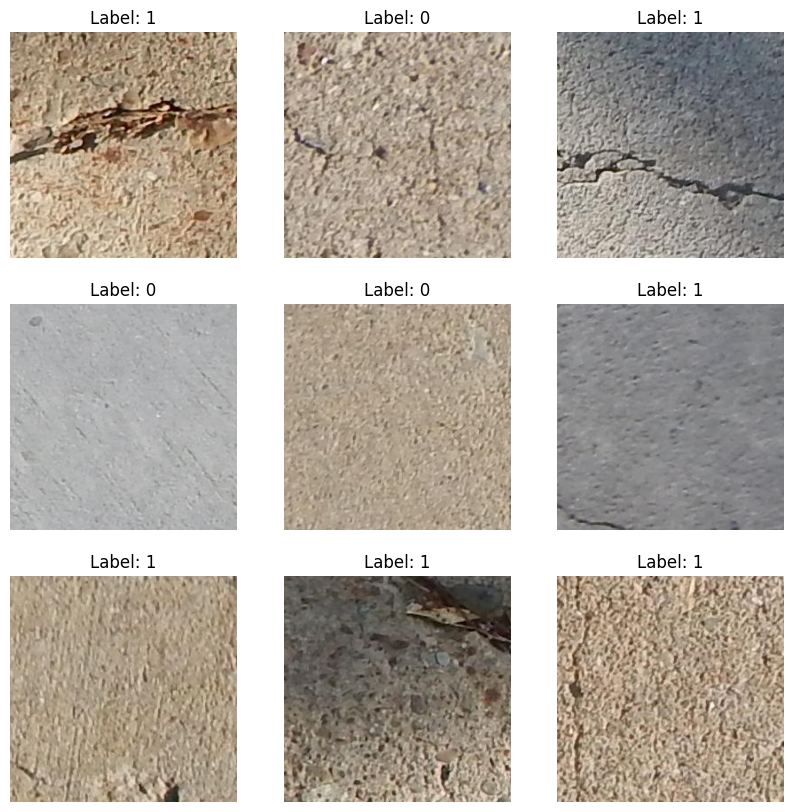

In [7]:
fig = plt.figure(figsize=(10, 10))

for i in range(9):
    fig.add_subplot(3, 3, (i+1))
    rand_idx = random.randint(0, len(train_df)-1)
    train_sample = train_df[['images', 'labels']].iloc[rand_idx]
    sample_img = Image.open(train_sample['images']).convert("RGB")
    plt.imshow(sample_img)
    plt.axis('off')
    plt.title(f"Label: {train_sample['labels']}")
    
plt.show()

In [8]:
class CrackDataset(Dataset):
    def __init__(self, df, transform=None):
        super().__init__()
        self.df_data = df.values
        self.transform = transform

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, idx):
        img_path, label = self.df_data[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [9]:
# define the input image dimensions
IMG_SIZE = 224

# define the batch size
BATCH_SIZE = 32

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet normalization
    ]),
    'valid': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)), # ImageNet normalization
    ])
}

dataloaders = {
    'train': DataLoader(CrackDataset(train_df, transform=data_transforms['train']), 
                        batch_size=BATCH_SIZE, shuffle=True, 
                        pin_memory=PIN_MEMORY, num_workers=4),
    'valid': DataLoader(CrackDataset(valid_df, transform=data_transforms['valid']), 
                        batch_size=BATCH_SIZE, shuffle=False, 
                        pin_memory=PIN_MEMORY, num_workers=4),
    'test': DataLoader(CrackDataset(test_df, transform=data_transforms['valid']), 
                       batch_size=1, shuffle=False,
                       pin_memory=PIN_MEMORY, num_workers=4)
}

Images batch shape: torch.Size([32, 3, 224, 224])
Labels batch shape: 32


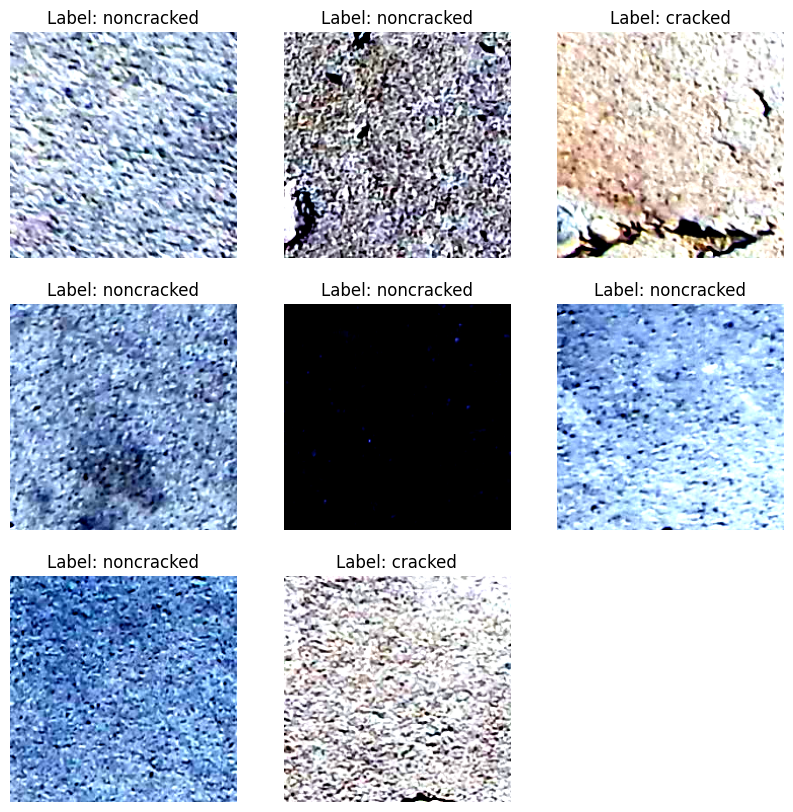

In [10]:
fig = plt.figure(figsize=(10, 10))

train_imgs, train_labels = next(iter(dataloaders['train']))
print(f"Images batch shape: {train_imgs.size()}")
print(f"Labels batch shape: {len(train_labels)}")

samples_from_batch = len(train_imgs)//4
for i in range(samples_from_batch):
    fig.add_subplot(samples_from_batch//3+1, 3, (i+1))
    plt.imshow(train_imgs[i].permute(1, 2, 0))
    plt.title(f"Label: {'cracked' if train_labels[i]==1 else 'noncracked'}")
    plt.axis('off')

plt.show()

# ViT (Vision Transformer) Architecture

In [24]:
model = models.vit_b_16(weights='DEFAULT')

for param in model.parameters():
    param.requires_grad = False
    
num_classes = len(df.labels.unique())
        
num_features_in = model.heads.head.in_features
model.heads.head = torch.nn.Linear(num_features_in, num_classes)

In [25]:
# model

In [26]:
# params_to_update = model.parameters()
# print("Params to learn:\n")
# if feature_extract:
#     params_to_update = []
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             params_to_update.append(param)
#             print(name)
# else:
#     for name,param in model.named_parameters():
#         if param.requires_grad == True:
#             print(name)

# Fine-tune ViT

In [27]:
# initialize learning rate, number of epochs to train for, and the batch size
INIT_LR = 1.5e-3
MOMENTUM = 0.9

# Send the model to GPU
model = model.to(DEVICE)

# Setup the loss function
criterion = torch.nn.CrossEntropyLoss()

# Model parameters where requires grad is True
params_to_tune = [param for param in model.parameters() if param.requires_grad]

# Observe that all parameters are being optimized
optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

In [28]:
# model = models.vit_b_16(weights='DEFAULT')

# for param in model.parameters():
#     param.requires_grad = False
    
# num_classes = len(df.labels.unique())
        
# num_features_in = model.heads.head.in_features
# model.heads.head = torch.nn.Linear(num_features_in, num_classes)

# # initialize learning rate, number of epochs to train for, and the batch size
# INIT_LR = 2.5e-3
# MOMENTUM = 0.9

# # Send the model to GPU
# model = model.to(DEVICE)

# # Setup the loss function
# criterion = torch.nn.CrossEntropyLoss()

# # Model parameters where requires grad is True
# params_to_tune = [param for param in model.parameters() if param.requires_grad]

# # Observe that all parameters are being optimized
# optimizer = optim.SGD(params_to_tune, lr=INIT_LR, momentum=MOMENTUM)

# NUM_EPOCHS = 10

# train_inputs, train_labels = next(iter(dataloaders['train']))
# val_inputs, val_labels = next(iter(dataloaders['valid']))

# # Train the model for the specified number of epochs
# for epoch in range(NUM_EPOCHS):
#     print(f'Epoch {epoch}')
#     # Set the model to train mode
#     model.train()

#     # Initialize the running loss and accuracy
#     batch_train_loss = 0.0
#     batch_train_corrects = 0

#     # # Iterate over the batches of the train loader
#     # for inputs, labels in train_loader:
#     # Move the inputs and labels to the device
#     train_inputs = train_inputs.to(DEVICE)
#     train_labels = train_labels.to(DEVICE)

#     # Forward pass
#     outputs = model(train_inputs)
#     _, preds = torch.max(outputs, 1)
#     loss = criterion(outputs, train_labels)
    
#     # Zero the optimizer gradients
#     optimizer.zero_grad()
    
#     # Backward pass and optimizer step
#     loss.backward()
#     optimizer.step()

#     # Update the running loss and accuracy
#     batch_train_loss += loss.item() * train_inputs.size(0)
#     batch_train_corrects += torch.sum(preds == train_labels.data)

# #     # Calculate the train loss and accuracy
# #     train_dataset_len = dataloaders['train'].dataset.__len__()
# #     train_epoch_loss = batch_loss / train_dataset_len
# #     train_epoch_acc = batch_corrects.double() / train_dataset_len

#     print(f'Train Loss: {batch_train_loss}, Train Accuracy: {batch_train_corrects/32}')
    
#     # Set the model to evaluation mode
#     model.eval()

#     # Initialize the running loss and accuracy
#     batch_val_loss = 0.0
#     batch_val_corrects = 0

#     # Iterate over the batches of the validation loader
#     with torch.no_grad():
# #         for inputs, labels in val_loader:
# #             # Move the inputs and labels to the device
#         val_inputs = val_inputs.to(DEVICE)
#         val_labels = val_labels.to(DEVICE)

#         # Forward pass
#         outputs = model(val_inputs)
#         _, preds = torch.max(outputs, 1)
#         loss = criterion(outputs, val_labels)

#         # Update the running loss and accuracy
#         batch_val_loss += loss.item() * val_inputs.size(0)
#         batch_val_corrects += torch.sum(preds == val_labels.data)
        
#     print(f'Validation Loss: {batch_val_loss}, Validation Accuracy: {batch_val_corrects/32}\n')



#     # Calculate the validation loss and accuracy
# #     val_loss = running_loss / len(val_dataset)
# #     val_acc = running_corrects.double() / len(val_dataset)

In [30]:
NUM_EPOCHS = 100

train_losses = []
val_losses = []

# Train the model for the specified number of epochs
for epoch in range(NUM_EPOCHS):
    train_loss, val_loss, train_acc, val_acc = train_one_epoch(model, dataloaders, criterion, optimizer)
    
    # Print the epoch results
    print('Epoch [{}/{}], train loss: {:.4f}, train acc: {:.4f}, val loss: {:.4f}, val acc: {:.4f}'
          .format(epoch+1, NUM_EPOCHS, train_loss, train_acc, val_loss, val_acc))
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

Epoch [1/100], train loss: 0.4212, train acc: 0.8008, val loss: 0.3208, val acc: 0.8812
Epoch [2/100], train loss: 0.3330, train acc: 0.8627, val loss: 0.3189, val acc: 0.8678
Epoch [3/100], train loss: 0.3180, train acc: 0.8615, val loss: 0.2789, val acc: 0.8985
Epoch [4/100], train loss: 0.3048, train acc: 0.8703, val loss: 0.2706, val acc: 0.9004
Epoch [5/100], train loss: 0.2948, train acc: 0.8708, val loss: 0.2737, val acc: 0.8927
Epoch [6/100], train loss: 0.2886, train acc: 0.8804, val loss: 0.2608, val acc: 0.9100
Epoch [7/100], train loss: 0.2824, train acc: 0.8816, val loss: 0.2907, val acc: 0.8678
Epoch [8/100], train loss: 0.2768, train acc: 0.8826, val loss: 0.2562, val acc: 0.9042
Epoch [9/100], train loss: 0.2717, train acc: 0.8871, val loss: 0.2534, val acc: 0.9004
Epoch [10/100], train loss: 0.2684, train acc: 0.8912, val loss: 0.2711, val acc: 0.8889
Epoch [11/100], train loss: 0.2639, train acc: 0.8907, val loss: 0.2541, val acc: 0.8966
Epoch [12/100], train loss: 0.

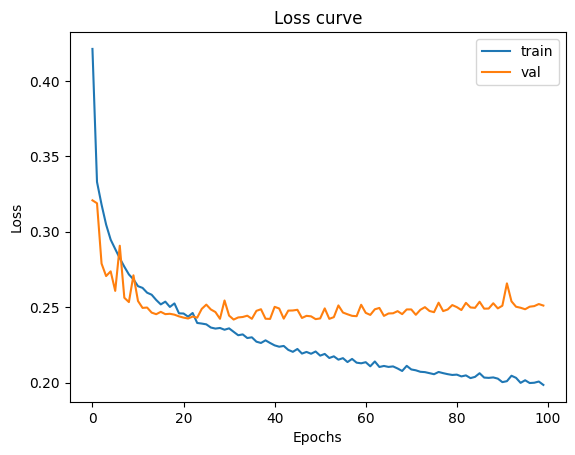

In [31]:
plt.title("Loss curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(train_losses, label="train")
plt.plot(val_losses, label="val")
plt.legend()
plt.show()

In [23]:
# def train_one_epoch(model, dataloaders, criterion, optimizer):
#     for phase in ['train', 'valid']:
#         if phase == 'train':
#             model.train()  # Set model to training mode
#         else:
#             model.eval()   # Set model to evaluate mode

#         running_loss = 0.0
#         running_corrects = 0

#         # Iterate over data.
#         for inputs, labels in dataloaders[phase]:
#             inputs = inputs.to(DEVICE)
#             labels = labels.to(DEVICE)

#             # zero the parameter gradients
#             optimizer.zero_grad()

#             # forward
#             # track history if only in train
#             with torch.set_grad_enabled(phase=='train'):
#                 # Get model outputs and calculate loss
#                 # Special case for inception because in training it has an auxiliary output. In train
#                 #   mode we calculate the loss by summing the final output and the auxiliary output
#                 #   but in testing we only consider the final output.
#                 outputs = model(inputs)
#                 loss = criterion(outputs, labels)

#                 _, preds = torch.max(outputs, 1)

#                 # backward + optimize only if in training phase
#                 if phase == 'train':
#                     loss.backward()
#                     optimizer.step()

#             # statistics
#             running_loss += loss.item() * inputs.size(0)
#             running_corrects += torch.sum(preds == labels.data)

#         epoch_loss = running_loss / len(dataloaders[phase].dataset)
#         epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
        
#         return epoch_loss, epoch_acc

# def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
#     since = time.time()

#     val_acc_history = []
    
#     best_model_wts = copy.deepcopy(model.state_dict())
#     best_acc = 0.0

#     for epoch in range(num_epochs):
#         print('Epoch {}/{}'.format(epoch, num_epochs - 1))
#         print('-' * 10)

        

#             print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

#             # deep copy the model
#             if phase == 'val' and epoch_acc > best_acc:
#                 best_acc = epoch_acc
#                 best_model_wts = copy.deepcopy(model.state_dict())
#             if phase == 'val':
#                 val_acc_history.append(epoch_acc)

#         print()

#     time_elapsed = time.time() - since
#     print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val Acc: {:4f}'.format(best_acc))

#     # load best model weights
#     model.load_state_dict(best_model_wts)
#     return model, val_acc_history

In [25]:
# Train and evaluate
model_ft, hist = train_model(model, dataloaders, criterion, optimizer, num_epochs=NUM_EPOCHS)

Epoch 0/99
----------


RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.
